In [20]:
%matplotlib inline
import astropy.io.fits as pyfits
import numpy as np
from astropy.utils.data import get_pkg_data_filename
import subprocess as sp
import scipy.ndimage as sci_nd
import glob
import matplotlib.pyplot as mpl
from astropy.table import Table
import sys
import os
from astropy.io import ascii

from astropy.visualization import astropy_mpl_style
mpl.style.use(astropy_mpl_style)

In [2]:
#from galfit on Bruno's github


def get_fixpars_default():
    r""" Returns the default dictionary containing the information on whether
    or not to fix any parameter of the fit. By default, all parameters are
    not fixed.
    Parameters
    ----------
    Returns
    -------
    fixpars : dict
        A dictionary for each of the sersic parameters setting the fix/free key.
    References
    ----------
    Examples
    --------
    """
    return {'x':1,'y':1,'m':1,'re':1,'n':1,'q':1,'pa':1,'sky':1}



def write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None):
    r""" Returns a string object containing a general description for a galaxy
    profile model in GALFIT, with the input parameters as first guesses.
    Parameters
    ----------
    model : str
    Returns
    -------
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    objString = ""
    objString += "#Object number: %i\n"%(num)
    objString += " 0) %s             # Object type\n"%(model)
    objString += " 1) %6.4f %6.4f  %i %i    # position x, y        [pixel]\n"%(x,y,fixpars['x'],fixpars['y'])
    objString += " 3) %4.4f      %i       # total magnitude\n"%(m,fixpars['m'])
    objString += " 4) %4.4f       %i       #     R_e              [Pixels]\n"%(re,fixpars['re'])
    objString += " 5) %4.4f       %i       # Sersic exponent (deVauc=4, expdisk=1)\n"%(n,fixpars['n'])
    objString += " 9) %4.4f       %i       # axis ratio (b/a)   \n"%(ba,fixpars['q'])
    objString += "10) %4.4f       %i       # position angle (PA)  [Degrees: Up=0, Left=90]\n"%(pa,fixpars['pa'])
    objString += " Z) 0                  #  Skip this model in output image?  (yes=1, no=0)\n"
    objString += " \n"
    return objString


def input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,imgname='input.fits',outname="output.fits",psfname='none',maskname="none",signame='none',fixpars=None):
    r""" Writes an input galfit file with the provided parameters.
    Parameters
    ----------
    f : file pointer
        Python file pointer to be written
    modelsString : str
        A single string containing the starting parameters of the models to be
        used. Model strings can be generated by the write_object function.
    magzpt : float
        Magnitude zeropoint of the image data. Needed for correct model
        magnitudes.
    sky : float
        Initial value for sky background (assumed to be constant)
    x_range : tuple, int
        X-axis boundaries to be used in image fitting (useful to fit a subset
        of a larger image).
    y_range : tuple, int
        Same as z_range, but for y-axis boundaries.
    sconvbox : int
        Size of the convolution box to be applied to the model image (should be
        at least the size of the PSF image).
    pixscale : float
        Pixel scale (in arcsecond/pixel) of the input image data
    imgname : str, optional
        Name of the image with the input data (default - input.fits)
    outname : str, optional
        Name of the output image block to be created by GALFIT
        (default - output.fits)
    psfname : str, optional
        Name of the psf fits file, to be used for model convolution
        (default - none, no psf used)
    maskname : str, optional
        Name of the mask file to be used in the fit. It mask bad pixel values
        and others (e.g. neighbor objects) that are ignored by the fitting
        algorithm (default - none, no mask used).
    signame : str, optional
        Error image corresponding to the input data.
        (default - none, sigma image created internally).
    fixpars : dict
        Dictionary which controls if parameters are fixed or not for the fit.
        This is used here to control wether the sky background is fixed or a
        free parameter for the fit.
    Returns
    -------
        None
        It writes to the file "f" and returns nothing.
    References
    ----------
    Examples
    --------
    """
    if fixpars is None:
        fixpars=get_fixpars_default()

    assert len(x_range)==len(y_range)==2,"x_range,y_range must have two elements"
    assert x_range[1]>x_range[0],"x_range must be sorted in ascendent order"
    assert y_range[1]>y_range[0],"y_range must be sorted in ascendent order"

    f.write("================================================================================\n")
    f.write("# IMAGE and GALFIT CONTROL PARAMETERS\n")
    f.write("A) %s         # Input data image (FITS file)\n"%imgname)
    f.write("B) %s        # Output data image block\n"%outname)
    f.write("C) %s                # Sigma image name (made from data if blank or 'none' \n"%signame)
    f.write("D) %s         # Input PSF image and (optional) diffusion kernel\n"%psfname)
    f.write("E) 1                   # PSF fine sampling factor relative to data \n")
    f.write("F) %s                # Bad pixel mask (FITS image or ASCII coord list)\n"%maskname)
    f.write("G) none                # File with parameter constraints (ASCII file) \n")
    f.write("H) %i    %i   %i    %i # Image region to fit (xmin xmax ymin ymax)\n"%(x_range[0],x_range[1],y_range[0],y_range[1]))
    f.write("I) %i    %i          # Size of the convolution box (x y)\n"%(sconvbox,sconvbox))
    f.write("J) %7.5f             # Magnitude photometric zeropoint \n"%magzpt)
    f.write("K) %.3f %.3f        # Plate scale (dx dy)   [arcsec per pixel]\n"%(pixscale,pixscale))
    f.write("O) regular             # Display type (regular, curses, both)\n")
    f.write("P) 0                   # Options: 0=normal run; 1,2=make model/imgblock and quit\n")
    f.write("\n")
    f.write("# INITIAL FITTING PARAMETERS\n")
    f.write("#\n")
    f.write("#For object type, the allowed functions are:\n")
    f.write("#nuker, sersic, expdisk, devauc, king, psf, gaussian, moffat,\n")
    f.write("#ferrer, and sky.\n")
    f.write("#\n")
    f.write("#Hidden parameters will only appear when theyre specified:\n")
    f.write("#C0 (diskyness/boxyness),\n")
    f.write("#Fn (n=integer, Azimuthal Fourier Modes).\n")
    f.write("#R0-R10 (PA rotation, for creating spiral structures).\n")
    f.write("#\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("#  par)    par value(s)    fit toggle(s)   parameter description\n")
    f.write("# ------------------------------------------------------------------------------\n")
    f.write("\n")

    f.write(modelsString)

    f.write("# Object: Sky\n")
    f.write(" 0) sky                    #  object type\n")
    f.write(" 1) %7.4f      %i          #  sky background at center of fitting region [ADUs]\n"%(sky,fixpars['sky']))
    f.write(" 2) 0.0000      0          #  dsky/dx (sky gradient in x)\n")
    f.write(" 3) 0.0000      0          #  dsky/dy (sky gradient in y)\n")
    f.write(" Z) 0                      #  output option (0 = resid., 1 = Dont subtract)")
    f.close()
    return

In [4]:
#One Filter to start
filters = {"F105W"}
zeropoints = {"F435W":25.665,"F606W":26.493,"F814W":25.97,"F105W":26.2687,"F125W":26.2303,"F140W":24.4524,\
              "F160W":25.9463, "F625W":24.85714771, "F775W":25.66195995, "F850LP":25.89943399}

#opening all files will need
detected_objs_file = ascii.read('/data1/rowland/testPSF_F105W.cat') #all detected objects
#dilated_mask = ascii.read('/data1/rowland/masks/dilated_mask_F105W.txt')
#mask_file = ascii.read('/data1/rowland/masks/undilated_mask_F105W.txt')
image_file = pyfits.open('/data1/rowland/elgordo_F105W.fits')
image_data = image_file[0].data 
#segmap_file = pyfits.open('/data1/rowland/segmaps_check/F105W_check.fits')
#segmap = segmap_file[0].data+0 #data as little endian

#only cluster galaxies - via tests in 1_PreparingGalFit-configfiles NB
short_detections_intermediate = np.where(detected_objs_file['MAG_AUTO']<20)
short_detections_stillstarstho = detected_objs_file[short_detections_intermediate]
B1 = .5 #red line
galselection_intermediate1 = np.where(short_detections_stillstarstho["MU_MAX"] > (short_detections_stillstarstho["MAG_AUTO"]-B1)) 
selection_ofgalaxies = short_detections_stillstarstho[galselection_intermediate1]
print('selection of galaxies:')
selection_ofgalaxies

selection of galaxies:


NUMBER,MAG_AUTO,KRON_RADIUS,ISOAREA_IMAGE,XPEAK_IMAGE,YPEAK_IMAGE,X_IMAGE,Y_IMAGE,A_IMAGE,THETA_IMAGE,MU_MAX,ELLIPTICITY,CLASS_STAR,FLUX_RADIUS
,mag,,pix2,pix,pix,pix,pix,pix,deg,mag / arcsec2,,,pix
int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
70,18.2507,3.5,6022,1667,842,1667.3851,842.0582,16.98,37.22,19.0108,0.527,0.921,9.893
236,19.873,4.81,3040,1545,1218,1545.1145,1218.0986,13.518,59.61,21.059,0.309,0.922,16.019
413,18.509,3.64,6377,2023,1761,2022.579,1761.2362,18.282,42.21,20.0029,0.441,0.107,13.258
815,19.5938,3.5,1797,2039,2057,2039.0352,2056.7297,10.212,-21.72,19.837,0.524,0.87,6.32
1429,19.4677,3.81,3475,2802,2912,2801.2766,2912.0305,13.029,28.94,20.4566,0.171,0.926,11.545
1450,19.7413,4.3,2001,2744,2911,2744.5549,2911.6685,11.035,52.73,20.8523,0.306,0.91,11.93
1506,19.6395,4.08,2239,3402,2972,3401.614,2972.3813,9.69,30.0,20.1289,0.21,0.906,8.879
1839,19.1615,3.5,2037,2692,3408,2692.2927,3408.125,11.211,-54.49,19.1786,0.61,0.952,6.201


## Write object per galaxy in cluster

In [5]:
#think i need these inital parameter values---maybe not

#outputtest = get_fixpars_default()
#print('type:',type(outputtest),'output',outputtest)#'shape:',outputtest.shape)
#outputtest['x']

In [15]:
#writing input file for galfit ---- these are the detections i want galfit to fit (ie cluster galaxies)


model = 'sersic' #from bruno
#m = 1 #from bruno
modelsList = []
for detection in selection_ofgalaxies: #to only run on subset for testing
    #print(detection)
    #get_fixpars_default()
    
    ## DEFINING PARAMETERS
    num = detection['NUMBER'] #my guess to make object number change
    ba = 1 - detection['ELLIPTICITY'] #from bruno
    pa = 90 - detection['THETA_IMAGE'] #from bruno
    x = detection['X_IMAGE'] #my guess
    y = detection['Y_IMAGE']
    re = detection['KRON_RADIUS']
    m = detection['MAG_AUTO']
    n = 1 #0=no,1=yes to skip this model, think this b/c want galfit to fit these 8 'cluster galaxies'
    
    list_of_strings = write_object(model,x,y,m,re,n,ba,pa,num,fixpars=None) 
    print('this is list of strings:',list_of_strings)
    
    #saving outputs to a list
    modelsList.append(list_of_strings)
    #converting list into string format
    modelsString = ''.join(modelsList)
    
print('this is modelsString:', modelsString)    

this is list of strings: #Object number: 70
 0) sersic             # Object type
 1) 1667.3851 842.0582  1 1    # position x, y        [pixel]
 3) 18.2507      1       # total magnitude
 4) 3.5000       1       #     R_e              [Pixels]
 5) 1.0000       1       # Sersic exponent (deVauc=4, expdisk=1)
 9) 0.4730       1       # axis ratio (b/a)   
10) 52.7800       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (yes=1, no=0)
 

this is list of strings: #Object number: 236
 0) sersic             # Object type
 1) 1545.1145 1218.0986  1 1    # position x, y        [pixel]
 3) 19.8730      1       # total magnitude
 4) 4.8100       1       #     R_e              [Pixels]
 5) 1.0000       1       # Sersic exponent (deVauc=4, expdisk=1)
 9) 0.6910       1       # axis ratio (b/a)   
10) 30.3900       1       # position angle (PA)  [Degrees: Up=0, Left=90]
 Z) 0                  #  Skip this model in output image?  (ye

In [16]:
#testing if a string
type(modelsString)


str

In [17]:
#defing parameters

##### THIS HAS BEEN WRITTEN ----DONT RERUN CELL, MUST START WITH AN EMPTY FILE FOR THIS TO WORK OR WILL REWRITE BLANK!!

  
f = open("/data1/rowland/F105W_galfit_test_folder/input_F105W.galfit", "w") #created a blank file to write to
magzpt = zeropoints['F105W'] #from zeropoints for this filter
sky = 0 #b/c images already background subtracted
x_range =  (0,4538) #from image_file[0].data.shape (x,y)
y_range = (0,4824)  #from image_file[0].data.shape (x,y)
sconvbox = 100 #(4824, 4538)
pixscale = 0.06

#these dont work idk why
#psfname = '/data1/rowland/F105W_galfit_test_folder/testPSF_F105W.cat'
#maskname = '/data1/rowland/F105W_galfit_test_folder/dilated_mask_F105W.txt' #0=nothing,1=object

#even these wont work!!! >_<
#psfname = 'none' 
#maskname = 'none'

strings_forgalfit = input_file(f,modelsString,magzpt,sky,x_range,y_range,sconvbox,pixscale,\
                               imgname='elgordo_F105W.fits',\
                               outname="output_F105W.fits",\
                               psfname='psf.fits',\
                               maskname='dilated_mask_F105W.fits',\
                               signame='none',fixpars=None)
f.close()


# Ran galfit in terminal.....below explores that output


In [22]:
output = pyfits.open('/data1/rowland/F105W_galfit_test_folder/output_F105W.fits')
output.info()

Filename: /data1/rowland/F105W_galfit_test_folder/output_F105W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (4538, 4824)   float32   
  1                1 ImageHDU        47   (4538, 4824)   float32   
  2                1 ImageHDU       106   (4538, 4824)   float32   
  3                1 ImageHDU         6   (4538, 4824)   float32   


In [24]:
#setting up to get each image
image = get_pkg_data_filename('/data1/rowland/F105W_galfit_test_folder/output_F105W.fits')
pyfits.info(image)

Filename: /data1/rowland/F105W_galfit_test_folder/output_F105W.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (4538, 4824)   float32   
  1                1 ImageHDU        47   (4538, 4824)   float32   
  2                1 ImageHDU       106   (4538, 4824)   float32   
  3                1 ImageHDU         6   (4538, 4824)   float32   


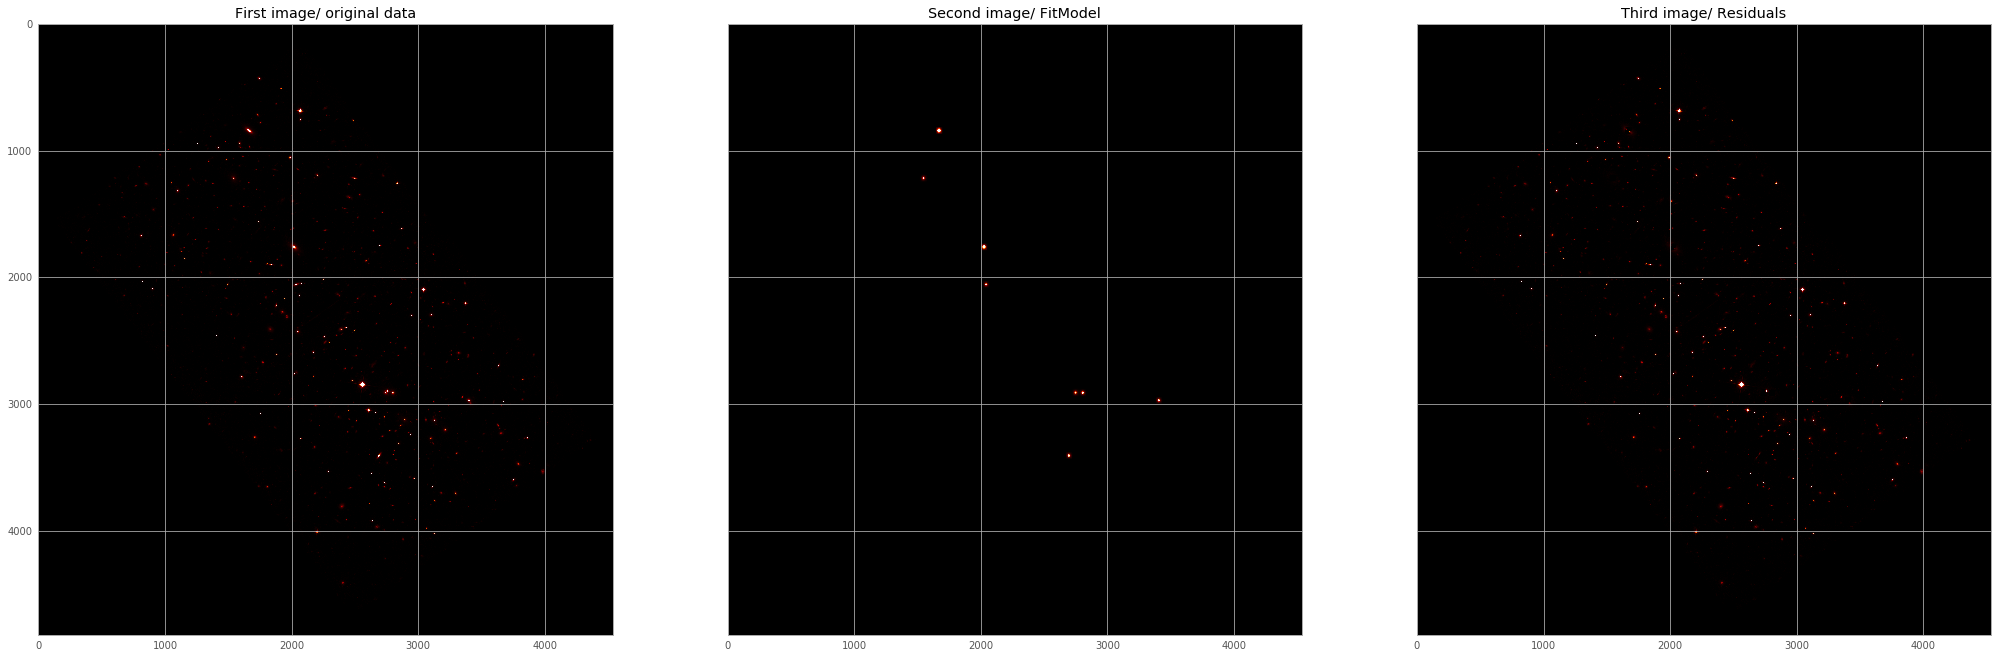

In [33]:
%matplotlib inline

#defining each image in output file
image_1 = pyfits.getdata(image, ext=1)
image_2 = pyfits.getdata(image, ext=2)
image_3 = pyfits.getdata(image, ext=3)

#plotting output images
f, (ax1,ax2,ax3) = mpl.subplots(1,3,sharey=True,figsize=(35,35))
ax1.imshow(image_1,vmin=0,vmax=1)
ax1.title.set_text('First image/ original data')
ax2.imshow(image_2,vmin=0,vmax=1)
ax2.title.set_text('Second image/ FitModel')
ax3.imshow(image_3,vmin=0,vmax=1)
ax3.title.set_text('Third image/ Residuals')
mpl.savefig('F105W_galfit_images')